In [1]:
from google.colab import drive,files
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from shutil import copyfile

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d muratkokludataset/grapevine-leaves-image-dataset
!unzip grapevine-leaves-image-dataset.zip

 88% 96.0M/109M [00:00<00:00, 153MB/s]
100% 109M/109M [00:01<00:00, 109MB/s] 
Archive:  grapevine-leaves-image-dataset.zip
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (1).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (10).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (100).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (11).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (12).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (13).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (14).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (15).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (16).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (17).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (18).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (19).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (2).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (20).png  
  inflating: Grapevine_L

Load Dataset & Visualize the Data of Each Class

In [4]:
img_d = "/content/Grapevine_Leaves_Image_Dataset"
labels_name = ['Ak',
 'Ala_Idris',
 'Buzgulu',
 'Dimnit',
 'Nazli']

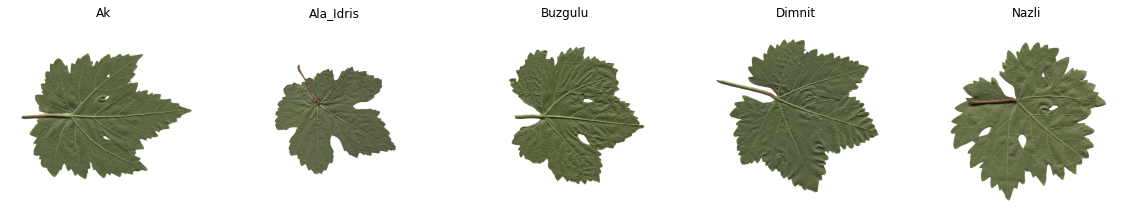

In [5]:
plt.figure(figsize=(20, 14))
for i in range(len(labels_name)):
  img = mpimg.imread(img_d+"/"+labels_name[i]+"/"+random.choice(os.listdir(img_d+"/"+labels_name[i])))
  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(labels_name[i])
  plt.axis(False)

Create Training & Testing Folders and Randomly Split Images into them

In [6]:
# Create Training & testing Folder
for x in ["training","testing"]:
  path = os.path.join(img_d, x)
  os.makedirs(path)
  for i in labels_name:
      os.makedirs(os.path.join(path,i))
training_dir = os.path.join(img_d,"training")
testing_dir = os.path.join(img_d,"testing")

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + ' is zero length, so ignoring.')

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
  
  for filename in training_set:
    src_file = SOURCE + filename
    dest_file = TRAINING + filename
    copyfile(src_file, dest_file)
    
  for filename in testing_set:
    src_file = SOURCE + filename
    dest_file = TESTING + filename
    copyfile(src_file, dest_file)

split_size = 0.8
for i in labels_name:
    label_source_dir = os.path.join(img_d, (str(i)+"/"))
    training_label_dir = os.path.join(training_dir, (str(i)+"/"))
    testing_label_dir = os.path.join(testing_dir, (str(i)+"/"))
    split_data(label_source_dir, training_label_dir, testing_label_dir, split_size)


In [8]:
# Normalize the Images And Create training & testing data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
train_data = train_datagen.flow_from_directory(training_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_data = test_datagen.flow_from_directory(testing_dir,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode="categorical")


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


### Function to Train, Visualize & Save a Model

In [9]:
# A super function to train, visualize & save the Model
def train_plot_save(modeln,name):
  # train the model on the dataset with 20 Epochs
  modeln.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  modeln.summary()
  history = modeln.fit(train_data,
              epochs=25,
              steps_per_epoch=len(train_data),
              validation_data=test_data,
              validation_steps=len(test_data))
  # Visualize the Findings
  plt.figure(figsize=(20, 7))
  # Summarize history of accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  print("\nSaving Model....")
  modeln.save(name)


# Model 1 - Basic CNN Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 4)                 602116    
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 5)                 25        
                                                                 
Total params: 602,161
Trainable params: 602,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
13/13 [==============================] - 5s 333ms/step - loss: 1.6107 - accuracy: 0.1900 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/25
13/13 [======================

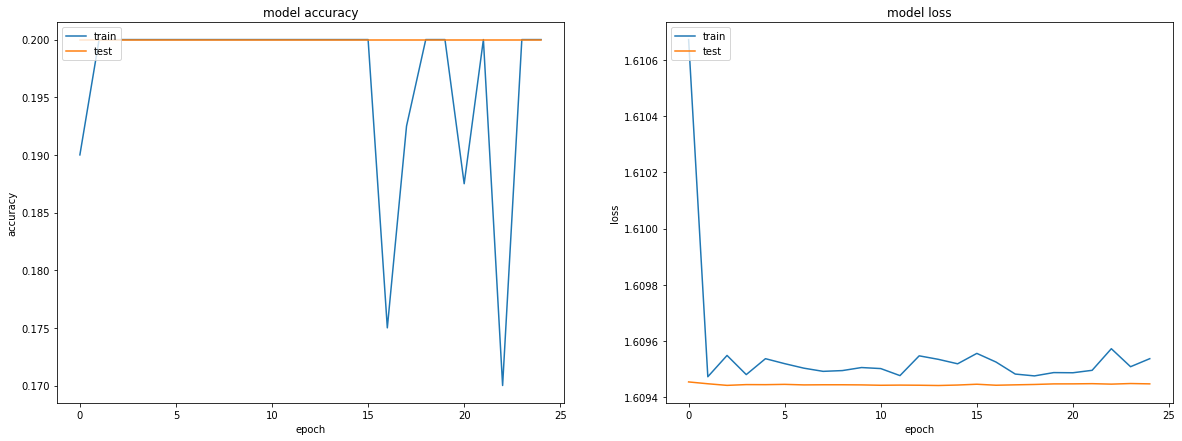

In [10]:
# Lets Start with Basic Model
basic_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(len(labels_name), activation="softmax")
])

train_plot_save(basic_model,"model1-basic.h5")

# Model 2 - Convolution & MaxPool Layers

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)           

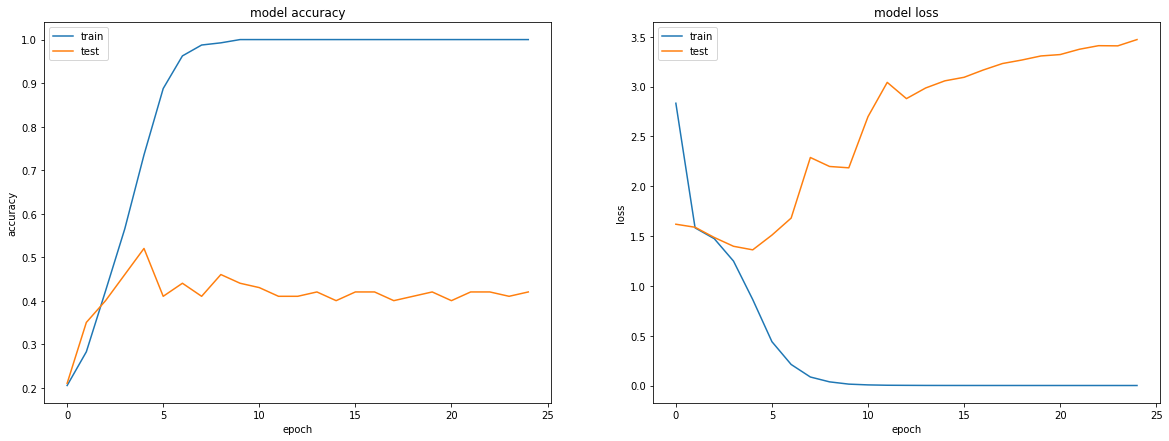

In [11]:
Conv_Model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(labels_name), activation='softmax')
])

train_plot_save(Conv_Model,"model2-conv.h5")

# Model 3 - Transfer Learning

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)                  

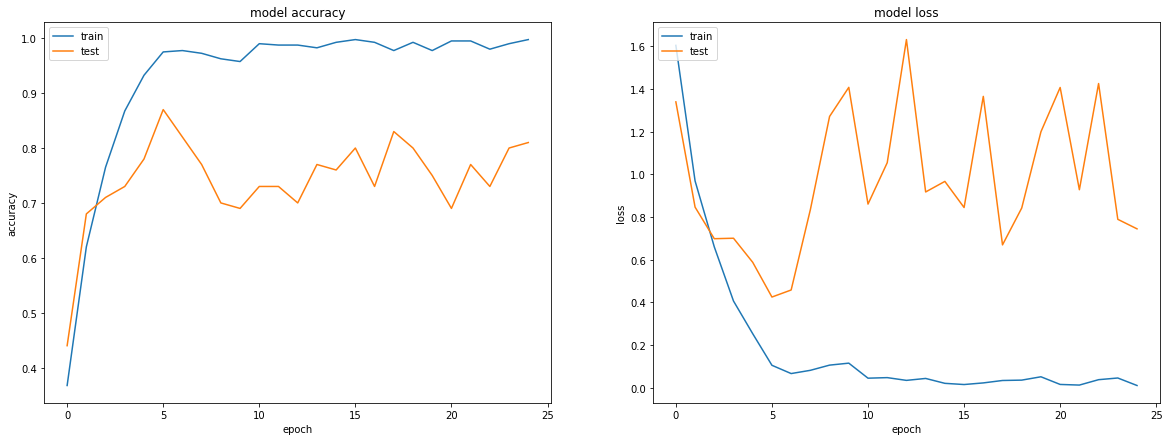

In [12]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output  = tf.keras.layers.Dense(units=5, activation='softmax')(x)
transfer_model = tf.keras.models.Model(InceptionV3_model.input, output)
train_plot_save(transfer_model,"model3-transfer.h5")